In [36]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas matplotlib scipy cartopy openmeteo_requests retry_requests

  Using cached Cartopy-0.23.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.0 kB)
  Using cached shapely-2.0.6-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (7.0 kB)
  Using cached pyshp-2.3.1-py2.py3-none-any.whl.metadata (55 kB)
  Using cached pyproj-3.7.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (31 kB)
Using cached Cartopy-0.23.0-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (11.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 730.6 kB/s eta 0:00:00m eta 0:00:010:00:01
Using cached pyshp-2.3.1-py2.py3-none-any.whl (46 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 1.2 MB/s eta 0:00:00m eta 0:00:010:01:010m


In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import geopandas as gpd
import cartopy.crs as ccrs

In [61]:
latitudes = np.arange(41.5, 43.02, 0.1)
longitudes = np.arange(8.5, 9.52, 0.1)

In [62]:
print(latitudes)
print(longitudes)

[41.5 41.6 41.7 41.8 41.9 42.  42.1 42.2 42.3 42.4 42.5 42.6 42.7 42.8
 42.9 43. ]
[8.5 8.6 8.7 8.8 8.9 9.  9.1 9.2 9.3 9.4 9.5]


In [63]:
latitudes_list = latitudes.round(1).tolist()
longitudes_list = longitudes.round(1).tolist()

In [64]:
l_latitudes = np.repeat(latitudes_list, len(longitudes)).tolist()
l_longitudes = np.tile(longitudes_list, len(latitudes)).tolist()

In [65]:
#print(l_latitudes)
#print(l_longitudes)

In [66]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": l_latitudes,
	"longitude": l_longitudes,
	"start_date": "2024-09-09",
	"end_date": "2024-09-09",
	"hourly": ["wind_speed_10m", "wind_direction_10m"]
}
responses = openmeteo.weather_api(url, params=params)


In [67]:
# Création du DataFrame à partir des coordonnées
wind_data = pd.DataFrame({'lat': l_latitudes, 'lon': l_longitudes, 'u': 0.0, 'v':0.0})


In [68]:
print(wind_data)

      lat  lon    u    v
0    41.5  8.5  0.0  0.0
1    41.5  8.6  0.0  0.0
2    41.5  8.7  0.0  0.0
3    41.5  8.8  0.0  0.0
4    41.5  8.9  0.0  0.0
..    ...  ...  ...  ...
171  43.0  9.1  0.0  0.0
172  43.0  9.2  0.0  0.0
173  43.0  9.3  0.0  0.0
174  43.0  9.4  0.0  0.0
175  43.0  9.5  0.0  0.0

[176 rows x 4 columns]


In [69]:
for i in range(len(l_latitudes)): #l_latitude correspond au nombre de points de la grille
    data = responses[i] #On prend le i-ème point de la grille
    
    hourl = data.Hourly() #On va chercher les données par heure
    hourl_wind_speed_10m = hourl.Variables(0).ValuesAsNumpy()
    hourl_wind_direction_10m = hourl.Variables(1).ValuesAsNumpy()
    hourl_data = {"date": pd.date_range(
        start = pd.to_datetime(hourl.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourl.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourl.Interval()),
        inclusive = "left"
    )}
    hourl_data["wind_speed_10m"] = hourl_wind_speed_10m
    hourl_data["wind_direction_10m"] = hourl_wind_direction_10m

    hourl_dataframe = pd.DataFrame(data = hourl_data)
    
    wind_spd_tmp = hourl_data["wind_speed_10m"][0] #0 correspond à l'heure 0h00 de la journée du 09/09/2024
    wind_dir_tmp = hourl_data["wind_direction_10m"][0]
    wind_direction_radians = np.deg2rad(wind_dir_tmp)
    
    wind_data.at[i, 'u'] = wind_spd_tmp * np.cos(wind_direction_radians)
    wind_data.at[i, 'v'] = wind_spd_tmp * np.sin(wind_direction_radians)


In [70]:
#print(wind_data.tail(20))

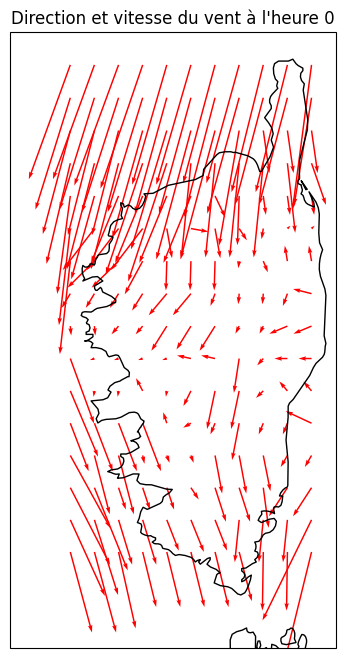

In [71]:
# Création de la carte
plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Mercator())

# Tracer les contours de la Corse
ax.coastlines()
ax.set_extent([8.25, 9.6, 41.2, 43.1], crs=ccrs.PlateCarree())
ax.set_title("Direction et vitesse du vent à l'heure 0")


ax.quiver(wind_data['lon'], wind_data['lat'], wind_data['u'], wind_data['v'], scale=100, transform=ccrs.PlateCarree(), color='r')

plt.show()

## Interpolation avec scipy.interpolate as interp

In [72]:
t1, t2 = np.meshgrid(latitudes, longitudes)

In [73]:
print(t1.shape, t2.shape)

(11, 16) (11, 16)


In [74]:
wind_data['u']

0       8.640039
1       8.640039
2       6.840027
3       5.400022
4       5.400022
         ...    
171   -12.960060
172   -13.320050
173   -12.960073
174   -12.960073
175    -7.919970
Name: u, Length: 176, dtype: float64

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.interpolate.interp2d.html#scipy.interpolate.interp2d

kind : {‘linear’, ‘cubic’, ‘quintic’}, optional

    The kind of spline interpolation to use. Default is ‘linear’.


In [75]:
from scipy.interpolate import interp2d, RectBivariateSpline
wind_data_u_grid = np.empty([len(latitudes), len(longitudes)], dtype = float)
print(wind_data_u_grid.shape)
wind_data_u_grid[:] = wind_data['u'].values[:wind_data_u_grid.size].reshape((16,11))


(16, 11)


In [76]:
import time

In [77]:
%%time
f_u = interp2d(longitudes,latitudes, wind_data_u_grid, kind='cubic')

NotImplementedError: `interp2d` has been removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
https://scipy.github.io/devdocs/tutorial/interpolate/interp_transition_guide.html


In [78]:
print(longitudes.size, wind_data_u_grid.shape)

11 (16, 11)


In [79]:
from scipy.interpolate import interp2d, RectBivariateSpline
wind_data_v_grid = np.empty([len(latitudes), len(longitudes)], dtype = float)
print(wind_data_v_grid.shape)
wind_data_v_grid[:] = wind_data['v'].values[:wind_data_v_grid.size].reshape((16,11))

f_v = interp2d(longitudes,latitudes, wind_data_v_grid, kind='cubic')

(16, 11)


NotImplementedError: `interp2d` has been removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
https://scipy.github.io/devdocs/tutorial/interpolate/interp_transition_guide.html


In [80]:
def plot(f, xnew, ynew, wind_data_grid):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
    znew = f(xnew, ynew)
    ax1.plot(longitudes, wind_data_grid[0, :], 'ro-', xnew, znew[0, :], 'b-')
    im = ax2.imshow(znew)
    plt.colorbar(im, ax=ax2)
    plt.show()
    return znew

In [81]:
print(wind_data_v_grid.shape, len(longitudes), len(latitudes))

(16, 11) 11 16


In [82]:
latitudes_interp = np.arange(41.5, 43.001, 1e-2)
longitudes_interp = np.arange(8.5, 9.5001, 1e-2)
wind_data_interp_u = plot(f_u, longitudes_interp, latitudes_interp, wind_data_u_grid)

NameError: name 'f_u' is not defined

In [126]:
%%time
test_u_interp = RectBivariateSpline(latitudes,longitudes,wind_data_u_grid, bbox=[min(latitudes), max(latitudes), min(longitudes), max(longitudes)])

CPU times: user 485 μs, sys: 0 ns, total: 485 μs
Wall time: 419 μs


In [127]:
%%time
test_v_interp = RectBivariateSpline(latitudes,longitudes,wind_data_v_grid, bbox=[min(latitudes), max(latitudes), min(longitudes), max(longitudes)])

CPU times: user 433 μs, sys: 56 μs, total: 489 μs
Wall time: 432 μs


In [128]:
u_interpolated = test_u_interp(latitudes_interp, longitudes_interp)
v_interpolated = test_v_interp(latitudes_interp, longitudes_interp)

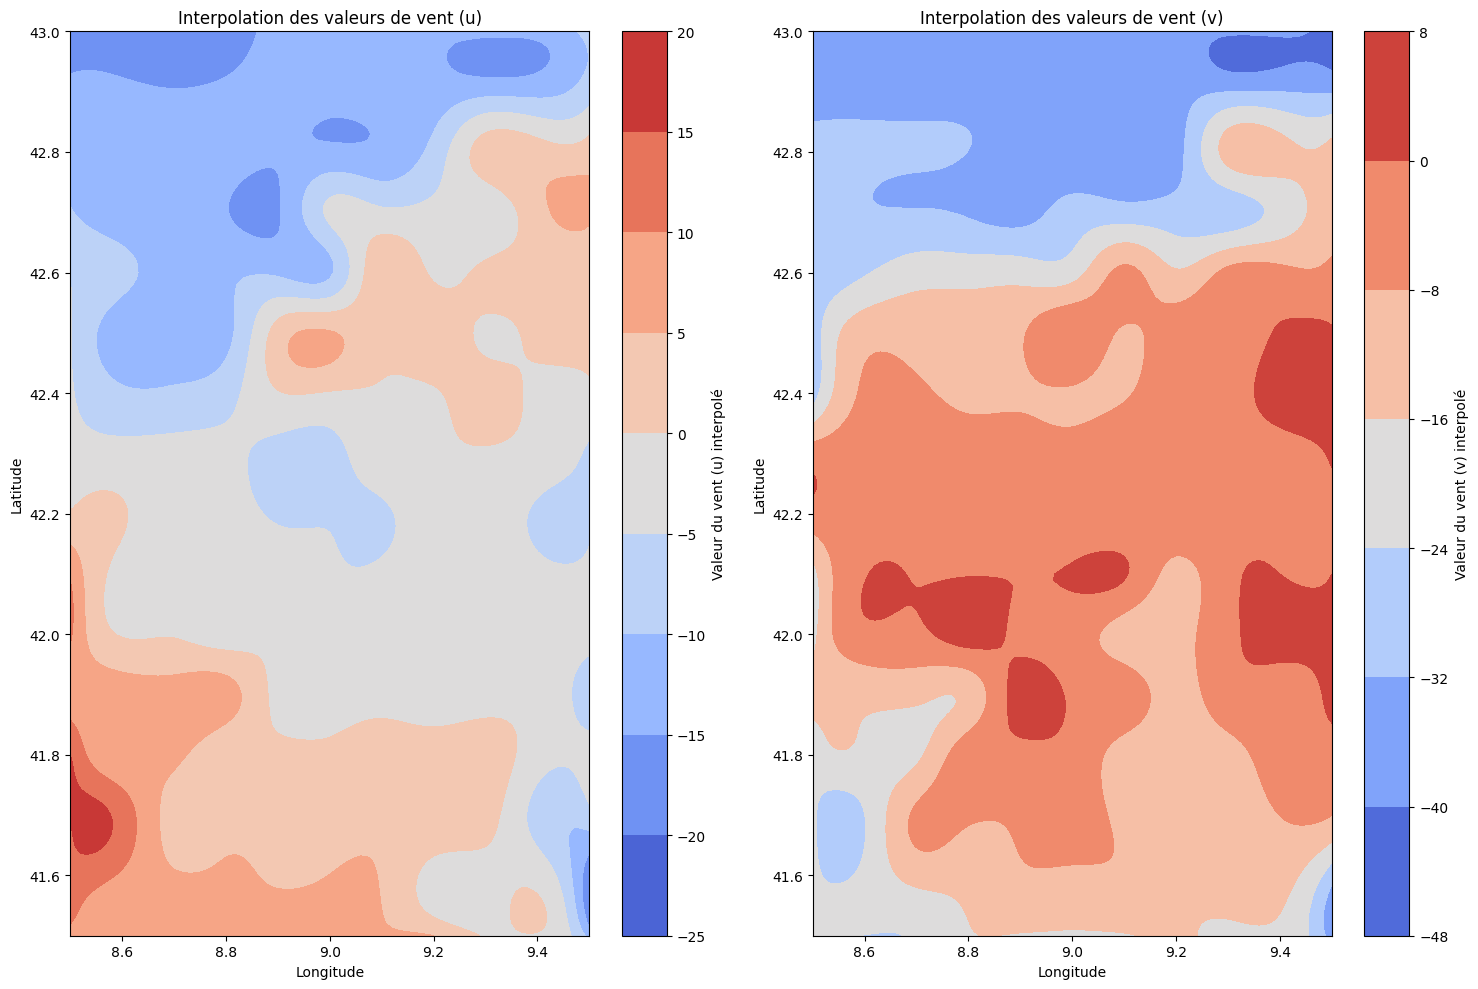

In [129]:
# Création d'une figure avec deux sous-graphes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))

# Carte de u_interpolated
contour_u = ax1.contourf(longitudes_interp, latitudes_interp, u_interpolated, cmap='coolwarm')
ax1.set_title('Interpolation des valeurs de vent (u)')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
fig.colorbar(contour_u, ax=ax1, label='Valeur du vent (u) interpolé')

# Carte de v_interpolated
contour_v = ax2.contourf(longitudes_interp, latitudes_interp, v_interpolated, cmap='coolwarm')
ax2.set_title('Interpolation des valeurs de vent (v)')
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
fig.colorbar(contour_v, ax=ax2, label='Valeur du vent (v) interpolé')

# Affiche les deux cartes côte à côte
plt.tight_layout()
plt.show()

In [ ]:
v_interpolated = test_v_interp(latitudes_interp, longitudes_interp)

In [27]:
type(wind_data_u_grid)

numpy.ndarray

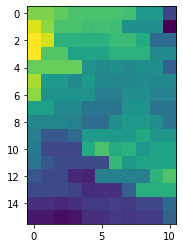

In [28]:
plt.imshow(wind_data_u_grid)
plt.show()

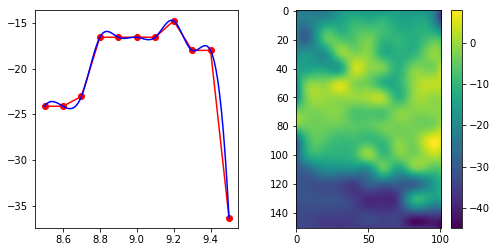

In [29]:
wind_data_interp_v = plot(f_v, longitudes_interp, latitudes_interp, wind_data_v_grid)

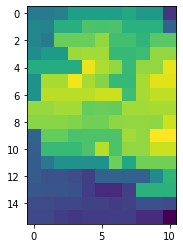

In [101]:
plt.imshow(wind_data_v_grid)
plt.show()

# Obtention des données pour le test

In [24]:
import numpy as np
import random

In [97]:
def generate_random_list(taille, borneInf, borneSup):
    return [round(random.uniform(borneInf, borneSup), 2) for _ in range(taille)]

nb_points_test = 100
latitudes_test = generate_random_list(nb_points_test, 41.5, 43)
longitudes_test = generate_random_list(nb_points_test, 8.5, 9.5)  


In [98]:
import openmeteo_requests

import requests_cache
import pandas as pd
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params_test = {
	"latitude": latitudes_test,
	"longitude": longitudes_test,
	"start_date": "2024-09-09",
	"end_date": "2024-09-09",
	"hourly": ["wind_speed_10m", "wind_direction_10m"]
}
responses_test = openmeteo.weather_api(url, params=params_test)


In [116]:
# Création du DataFrame à partir des coordonnées
wind_data_test = pd.DataFrame({'lat': latitudes_test, 'lon': longitudes_test, 'u': 0.0, 'v':0.0, 'u_interp' : 0.0, 'v_interp' : 0.0})


In [117]:
for i in range(len(latitudes_test)): #l_latitude correspond au nombre de points de la grille
    data_test = responses_test[i] #On prend le i-ème point de la grille
    
    hourl_test = data_test.Hourly() #On va chercher les données par heure
    hourl_wind_speed_10m_test = hourl_test.Variables(0).ValuesAsNumpy()
    hourl_wind_direction_10m_test = hourl_test.Variables(1).ValuesAsNumpy()
    hourl_data_test = {"date": pd.date_range(
        start = pd.to_datetime(hourl_test.Time(), unit = "s", utc = True),
        end = pd.to_datetime(hourl_test.TimeEnd(), unit = "s", utc = True),
        freq = pd.Timedelta(seconds = hourl_test.Interval()),
        inclusive = "left"
    )}
    hourl_data_test["wind_speed_10m"] = hourl_wind_speed_10m_test
    hourl_data_test["wind_direction_10m"] = hourl_wind_direction_10m_test

    hourl_dataframe_test = pd.DataFrame(data = hourl_data_test)
    
    wind_spd_tmp = hourl_data_test["wind_speed_10m"][0] #0 correspond à l'heure 0h00 de la journée du 09/09/2024
    wind_dir_tmp = hourl_data_test["wind_direction_10m"][0]
    wind_direction_radians = np.deg2rad(wind_dir_tmp)
    
    wind_data_test.at[i, 'u'] = wind_spd_tmp * np.cos(wind_direction_radians)
    wind_data_test.at[i, 'v'] = wind_spd_tmp * np.sin(wind_direction_radians)


In [118]:
print(wind_data_test)

      lat   lon          u          v  u_interp  v_interp
0   42.90  9.34 -11.520060 -32.039974       0.0       0.0
1   42.45  8.72  -9.359989  -6.840014       0.0       0.0
2   41.83  9.45   0.359993  -7.560000       0.0       0.0
3   42.23  8.54   0.359994  -2.880001       0.0       0.0
4   42.13  9.24  -1.800007  -6.839998       0.0       0.0
..    ...   ...        ...        ...       ...       ...
95  42.51  8.66 -11.519983 -11.160017       0.0       0.0
96  42.14  9.30  -1.799999  -1.440001       0.0       0.0
97  41.72  9.25   4.320002 -10.079999       0.0       0.0
98  42.19  9.23  -1.440001  -2.159999       0.0       0.0
99  42.77  8.57 -11.160046 -30.959986       0.0       0.0

[100 rows x 6 columns]


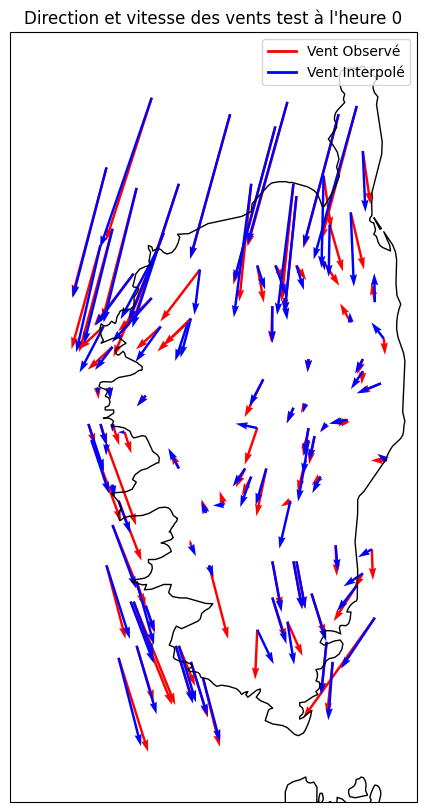

In [143]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib.lines import Line2D

# Création de la carte
plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.Mercator())

# Tracer les contours de la Corse
ax.coastlines()
ax.set_extent([8.25, 9.6, 41.2, 43.1], crs=ccrs.PlateCarree())
ax.set_title("Direction et vitesse des vents test à l'heure 0")

# Tracer les vecteurs de vent
quiver1 = ax.quiver(wind_data_test['lon'], wind_data_test['lat'], wind_data_test['u'], wind_data_test['v'], scale=100, transform=ccrs.PlateCarree(), color='r', label='Vent Observé')
quiver2 = ax.quiver(wind_data_test['lon'], wind_data_test['lat'], wind_data_test['u_interp'], wind_data_test['v_interp'], scale=100, transform=ccrs.PlateCarree(), color='b', label='Vent Interpolé')

# Créer des éléments de légende
legend_elements = [
    Line2D([0], [0], color='red', lw=2, label='Vent Observé'),
    Line2D([0], [0], color='blue', lw=2, label='Vent Interpolé')
]

# Ajouter la légende
ax.legend(handles=legend_elements, loc='upper right')

plt.show()


In [108]:
wind_data_test['u'][0]

np.float64(-11.520059585571289)

In [136]:
error_L1 = 0
error_L2 = 0
for i in range(nb_points_test):
    u_interpolated_test = test_u_interp(latitudes_test[i], longitudes_test[i])
    v_interpolated_test = test_v_interp(latitudes_test[i], longitudes_test[i])
    wind_data_test.loc[i, 'u_interp'] = u_interpolated_test
    wind_data_test.loc[i, 'v_interp'] = v_interpolated_test
    error_L1 += np.abs(u_interpolated_test - wind_data_test.loc[i, 'u']) + np.abs(v_interpolated_test - wind_data_test.loc[i, 'v'])
    error_L2 += (u_interpolated_test - wind_data_test['u'][i])**2 + (v_interpolated_test - wind_data_test['v'][i])**2

In [137]:
print(error_L1, error_L2)

[[458.06318505]] [[2690.64139836]]


In [139]:
print(wind_data_test.head(20))

      lat   lon          u          v   u_interp   v_interp
0   42.90  9.34 -11.520060 -32.039974 -11.483510 -31.731617
1   42.45  8.72  -9.359989  -6.840014 -11.300405  -9.265398
2   41.83  9.45   0.359993  -7.560000  -3.600710  -1.546595
3   42.23  8.54   0.359994  -2.880001   0.165331  -1.897971
4   42.13  9.24  -1.800007  -6.839998  -1.422587  -6.636454
5   42.01  9.05  -2.880002  -4.319998  -3.475993  -7.196134
6   41.95  9.18  -2.519999  -1.080001  -3.594362 -11.510033
7   41.84  9.33   0.359993  -7.560000   0.716768  -6.358724
8   42.53  9.20   2.879995  -3.240005   2.409226  -5.824153
9   42.18  9.19  -2.159997  -3.600002  -2.030621  -3.580868
10  41.55  8.85   5.400014 -13.319994   5.286881 -12.861096
11  41.71  9.12   4.320002 -10.079999   4.477885 -11.044705
12  41.84  8.85  -0.360001   1.440000   1.553498  -2.552740
13  41.59  8.81   5.039981  -9.360009   5.443115 -13.476020
14  42.01  9.28  -2.519997  -1.800004  -2.548830  -3.785352
15  42.94  8.72 -14.760008 -33.839996 -1

In [42]:
tmp = np.empty([len(latitudes), len(longitudes)], dtype = float)

In [52]:
wind_data['u'].values.size

176

In [46]:
tmp.size

176

In [16]:
N_sparse = 6
u_mesh = np.zeros((len(t1), len(t2)))
epsilon = 1e-1
for long, lat in zip(t1, t2):
    tmp = 0
    for i in range(len(long)):
        matches = (
            (np.abs(wind_data['lon'] - long[i]) < epsilon) &
            (np.abs(wind_data['lat'] - lat[i]) < epsilon)
        )
        u_values = wind_data.loc[matches, 'u']
        #print(long[i], lat[i])
        #print(wind_data.at[i, 'lon'])
        #print(wind_data.at[i, 'lat'])
        #print(wind_data.loc[wind_data['lon'] == long[i], 'u'])
        #u_mesh[tmp, i] = wind_data.loc[(wind_data['lon'] == round(long[i], 1)) & (wind_data['lat'] == lat[i]), 'u'].values
        #print(wind_data.loc[(round(wind_data['lon'], 1) == round(long[i], 1)) & (round(wind_data['lat'], 1) == round(lat[i], 1)), 'u'].values)
        


In [17]:
print(u_values.values)

[]


In [18]:
print(wind_data.loc[(wind_data['lon'] == 8.5) & (wind_data['lat'] == 41.6), 'u'])

11    13.319978
Name: u, dtype: float64


In [19]:
print(wind_data.head(40))

     lat  lon          u          v
0   41.5  8.5   8.640039 -24.119986
1   41.5  8.6   8.640039 -24.119986
2   41.5  8.7   6.840027 -23.039993
3   41.5  8.8   5.400022 -16.559992
4   41.5  8.9   5.400022 -16.559992
5   41.5  9.0   5.400022 -16.559992
6   41.5  9.1   5.400022 -16.559992
7   41.5  9.2   5.040019 -14.759993
8   41.5  9.3  -0.359996 -18.000000
9   41.5  9.4  -0.359996 -18.000000
10  41.5  9.5 -11.880054 -36.359982
11  41.6  8.5  13.319978 -21.960014
12  41.6  8.6   9.360011 -22.319996
13  41.6  8.7   5.400014 -13.319994
14  41.6  8.8   5.400014 -13.319994
15  41.6  8.9   4.679984  -9.000009
16  41.6  9.0   5.039981  -9.360009
17  41.6  9.1   4.679984  -9.000009
18  41.6  9.2  -1.799977 -12.960003
19  41.6  9.3  -1.799977 -12.960003
20  41.6  9.4  -1.799977 -12.960003
21  41.6  9.5 -18.720005 -28.799992
22  41.7  8.5  15.120026 -21.959980
23  41.7  8.6  12.959956 -24.120022
24  41.7  8.7   2.880000  -6.480000
25  41.7  8.8   2.880000  -6.480000
26  41.7  8.9   2.880000  -6

In [20]:
wind_data_u = np.zeros((len(latitudes), len(longitudes)))
wind_data_v = np.zeros((len(latitudes), len(longitudes)))


In [21]:
print(longitudes[10])
print(latitudes[15])

9.499999999999996
43.00000000000002


In [29]:
for i in range(len(latitudes)):
    for j in range(len(longitudes)):
        wind_data_u[i, j] = wind_data.loc[(wind_data['lon'] == round(longitudes[j],1)) & (wind_data['lat'] == round(latitudes[i],1)), 'u']
        wind_data_u[i, j] = wind_data.loc[(wind_data['lon'] == round(longitudes[j],1)) & (wind_data['lat'] == round(latitudes[i],1)), 'v']

/tmp/ipykernel_4044/1314122648.py:3: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wind_data_u[i, j] = wind_data.loc[(wind_data['lon'] == round(longitudes[j],1)) & (wind_data['lat'] == round(latitudes[i],1)), 'u']
/tmp/ipykernel_4044/1314122648.py:4: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  wind_data_u[i, j] = wind_data.loc[(wind_data['lon'] == round(longitudes[j],1)) & (wind_data['lat'] == round(latitudes[i],1)), 'v']


In [23]:
for i in range(len(latitudes)):
    for j in range(len(longitudes)):
        print(round(latitudes[i],1),round(longitudes[j],1), wind_data_u[i, j])

41.5 8.5 -24.119985580444336
41.5 8.6 -24.119985580444336
41.5 8.7 -23.039993286132812
41.5 8.8 -16.55999183654785
41.5 8.9 -16.55999183654785
41.5 9.0 -16.55999183654785
41.5 9.1 -16.55999183654785
41.5 9.2 -14.759992599487305
41.5 9.3 -18.0
41.5 9.4 -18.0
41.5 9.5 -36.359981536865234
41.6 8.5 -21.96001434326172
41.6 8.6 -22.319995880126953
41.6 8.7 -13.31999397277832
41.6 8.8 -13.31999397277832
41.6 8.9 -9.000008583068848
41.6 9.0 -9.36000919342041
41.6 9.1 -9.000008583068848
41.6 9.2 -12.960002899169922
41.6 9.3 -12.960002899169922
41.6 9.4 -12.960002899169922
41.6 9.5 -28.799991607666016
41.7 8.5 -21.959980010986328
41.7 8.6 -24.12002182006836
41.7 8.7 -6.480000019073486
41.7 8.8 -6.480000019073486
41.7 8.9 -6.480000019073486
41.7 9.0 -3.2400050163269043
41.7 9.1 -10.079998970031738
41.7 9.2 -10.079998970031738
41.7 9.3 -12.240002632141113
41.7 9.4 -7.920009613037109
41.7 9.5 -7.920009613037109
41.8 8.5 -20.519973754882812
41.8 8.6 -17.639989852905273
41.8 8.7 -17.639989852905273
4

In [24]:

from scipy.interpolate import griddata

# Convertir les listes en tableaux numpy
latitudes = np.array(latitudes)
longitudes = np.array(longitudes)
u_values = np.array(wind_data_u)


In [30]:
u_values

array([[-2.41199856e+01, -2.41199856e+01, -2.30399933e+01,
        -1.65599918e+01, -1.65599918e+01, -1.65599918e+01,
        -1.65599918e+01, -1.47599926e+01, -1.80000000e+01,
        -1.80000000e+01, -3.63599815e+01],
       [-2.19600143e+01, -2.23199959e+01, -1.33199940e+01,
        -1.33199940e+01, -9.00000858e+00, -9.36000919e+00,
        -9.00000858e+00, -1.29600029e+01, -1.29600029e+01,
        -1.29600029e+01, -2.87999916e+01],
       [-2.19599800e+01, -2.41200218e+01, -6.48000002e+00,
        -6.48000002e+00, -6.48000002e+00, -3.24000502e+00,
        -1.00799990e+01, -1.00799990e+01, -1.22400026e+01,
        -7.92000961e+00, -7.92000961e+00],
       [-2.05199738e+01, -1.76399899e+01, -1.76399899e+01,
        -2.51999903e+00, -2.16000128e+00, -2.16000128e+00,
        -1.15199995e+01, -1.15199995e+01, -1.07999983e+01,
        -3.23999763e+00, -3.23999763e+00],
       [-1.40400124e+01, -1.40400124e+01, -1.40400124e+01,
        -1.40400124e+01,  3.24000001e+00, -1.08000124e+00,
  

In [25]:

# Créer une grille de points pour l'interpolation
grid_lat = np.linspace(latitudes.min(), latitudes.max(), 100)
grid_lon = np.linspace(longitudes.min(), longitudes.max(), 100)
grid_lon, grid_lat = np.meshgrid(grid_lon, grid_lat)


In [26]:
print(grid_lon.shape, grid_lat.shape)

(100, 100) (100, 100)


In [27]:

# Interpolation des valeurs de u
grid_u = griddata((longitudes, latitudes), u_values, (grid_lon, grid_lat), method='linear')


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (11,) and arg 1 with shape (16,).

In [ ]:

# Visualisation des résultats
plt.figure(figsize=(12, 8))
plt.imshow(grid_u, extent=(longitudes.min(), longitudes.max(), latitudes.min(), latitudes.max()),
           origin='lower', cmap='viridis', alpha=0.7)
plt.scatter(longitudes, latitudes, c='red', marker='o', label='Données originales')
plt.colorbar(label='Valeurs de u')
plt.title('Interpolation des valeurs de u')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()

In [71]:
print(len(latitudes) , len(longitudes) )
wind_data_u.shape

16 11


(15, 10)

In [72]:
print(wind_data_u.shape)
print(np.min(wind_data_u,axis=0))
print(np.max(wind_data_u,axis=0))

(15, 10)
[-33.11999512 -33.11999512 -33.83999634 -33.83998871 -35.27998352
 -38.51996994 -38.51996994 -34.91999054 -32.03997421 -32.03997421]
[-2.88000059 -0.36000049 -0.36000049  3.59999657  3.24000001  0.71999472
  0.71999472 -2.15999913 -1.79999828  4.67999983]


TypeError: Dimensions of C (15, 10) are incompatible with X (16) and/or Y (11); see help(pcolormesh)

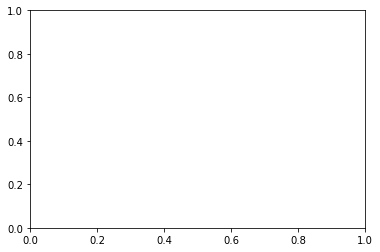

In [73]:
plt.figure()

lims = dict(cmap='RdBu_r', vmin=-20, vmax=20)

plt.pcolormesh(latitudes, longitudes, wind_data_u, shading='flat', **lims)

plt.colorbar()

plt.title("Sparsely sampled function.")

plt.show()

help(plt.pcolormesh)

In [124]:
from scipy.interpolate import RegularGridInterpolator

test_v = RegularGridInterpolator((np.array(latitudes), np.array(longitudes)), wind_data_v_grid)

In [125]:
test_v((42,8.5))

array(-19.0800209)

In [21]:
latitudes_interp = np.arange(41.5, 43.001, 1e-2)
longitudes_interp = np.arange(8.5, 9.5001, 1e-2)
wind_data_interp_v_test = plot(test_v, longitudes_interp, latitudes_interp, wind_data_v_grid)

NameError: name 'test_v' is not defined

In [123]:
# interpolator

ax.plot_wireframe(np.array(latitudes), np.array(longitudes), test_v((np.array(latitudes), np.array(longitudes))), rstride=3, cstride=3,

                  alpha=0.4, color='m', label='linear interp')

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (16,) and arg 1 with shape (11,).

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (16,) and arg 1 with shape (11,).

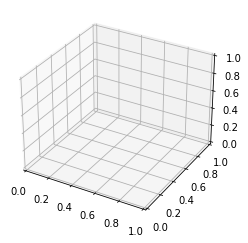

In [121]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(latitudes.ravel(), longitudes.ravel(), wind_data_v_grid.ravel(), s=60, c='k', label='data')

## Interpolation avec Lagrange

In [23]:
import numpy as np
from scipy.interpolate import lagrange
import matplotlib.pyplot as plt

In [24]:
u_new = np.arange(41.5, 43.01, 0.02)
v_new = np.arange(8.5, 9.51, 0.02)

In [25]:
# Interpoler d'abord dans la direction x, puis y
def interpolate_lagrange_2d(x, y, values, x_new, y_new):
    # Interpolation sur chaque ligne pour chaque nouvelle valeur de x
    interpolated_rows = np.zeros((len(y), len(x_new)))
    for i, row in enumerate(values):
        # Interpoler pour chaque ligne (en fonction de x)
        lagrange_poly = lagrange(x, row)
        interpolated_rows[i] = lagrange_poly(x_new)

    # Interpolation sur chaque colonne pour chaque nouvelle valeur de y
    interpolated_values = np.zeros((len(y_new), len(x_new)))
    for j in range(len(x_new)):
        lagrange_poly = lagrange(y, interpolated_rows[:, j])
        interpolated_values[:, j] = lagrange_poly(y_new)

    return interpolated_values


In [26]:
# Interpoler u et v sur la nouvelle grille
u_interp = interpolate_lagrange_2d(wind_data['lon'], wind_data['lat'], wind_data['u'], u_new, v_new)
v_interp = interpolate_lagrange_2d(wind_data['lon'], wind_data['lat'], wind_data['v'], u_new, v_new)


TypeError: 'float' object is not subscriptable

In [27]:
# Visualiser le champ vectoriel interpolé
U_new, V_new = np.meshgrid(u_new, v_new)

plt.figure(figsize=(6, 6))
plt.quiver(U_new, V_new, u_interp, v_interp)
plt.title("Champ vectoriel interpolé par Lagrange")
plt.show()

NameError: name 'u_interp' is not defined

<Figure size 432x432 with 0 Axes>